# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [47]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [48]:
max_iterations = 400
loop_count = 13

In [49]:

dev_1 = qml.device('default.qubit', wires=2)
dev_2 = qml.device('default.qubit', wires=2)
dev_3 = qml.device('default.qubit', wires=2)

## Classifier 1
init_weights_1 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
init_weights_2 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
init_weights_3 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


In [50]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

Loop count: 0


/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6801147 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     2 | Cost: 1.6800282 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     1 | Cost: 1.6053681 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     2 | Cost: 1.6053805 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     1 | Cost: 1.6802381 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6797294 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 


/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2139776 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2129133 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5200000 
Iter:     1 | Cost: 1.1792083 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.1794222 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     1 | Cost: 1.2187464 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2185405 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5100000 


/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4262674 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4281114 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     1 | Cost: 0.4703532 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     2 | Cost: 0.4671615 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     1 | Cost: 0.4372198 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:     2 | Cost: 0.4413582 | Acc train: 0.8800000 | Acc val: 0.9200000 | Acc all: 0.8800000 


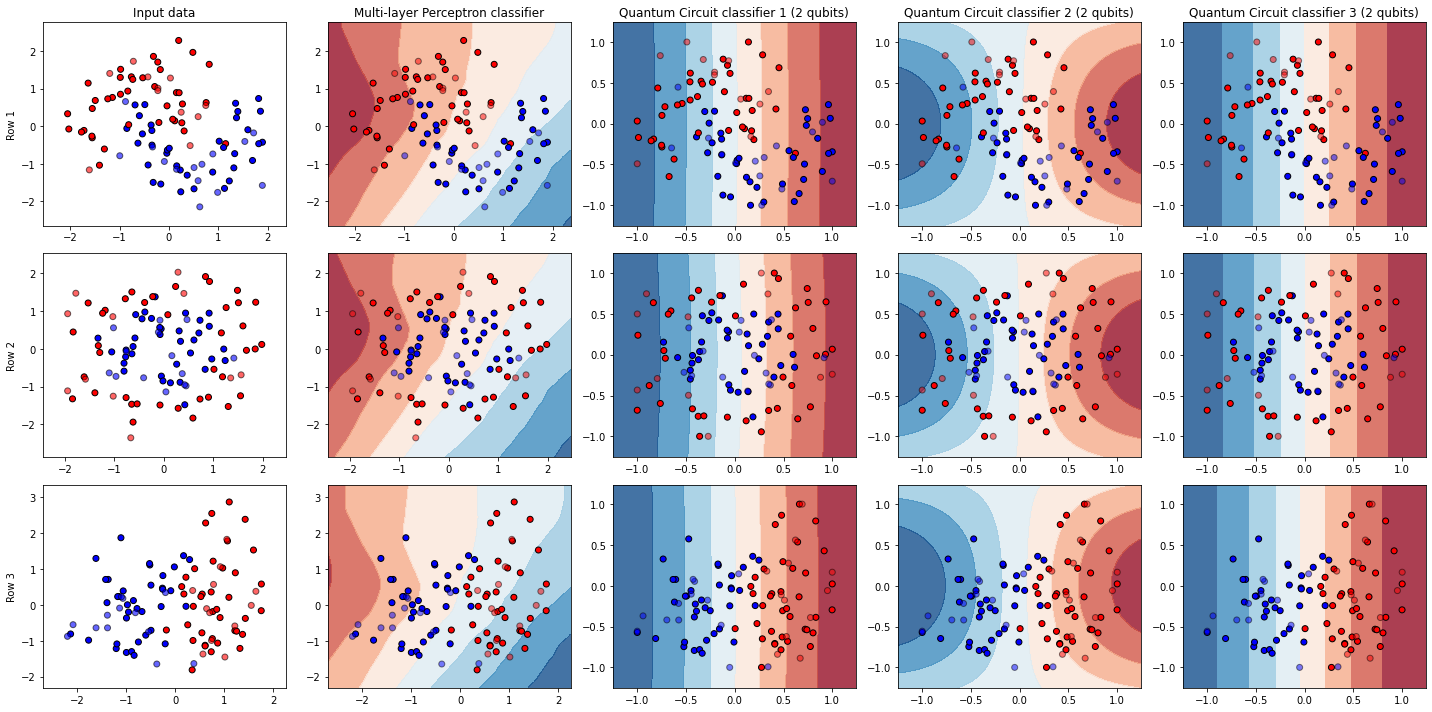

Loop count: 1


/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6801214 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     2 | Cost: 1.6806834 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     1 | Cost: 1.6060288 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6065435 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     1 | Cost: 1.6794479 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     2 | Cost: 1.6816064 | Acc train: 0.3600000 | Acc val: 0.3200000 | Acc all: 0.3500000 


/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2137331 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2134015 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5200000 
Iter:     1 | Cost: 1.1782680 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.1781146 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     1 | Cost: 1.2202085 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2187450 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 


/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4262162 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4253590 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     1 | Cost: 0.4783183 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4781832 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     1 | Cost: 0.4320604 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4281301 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 


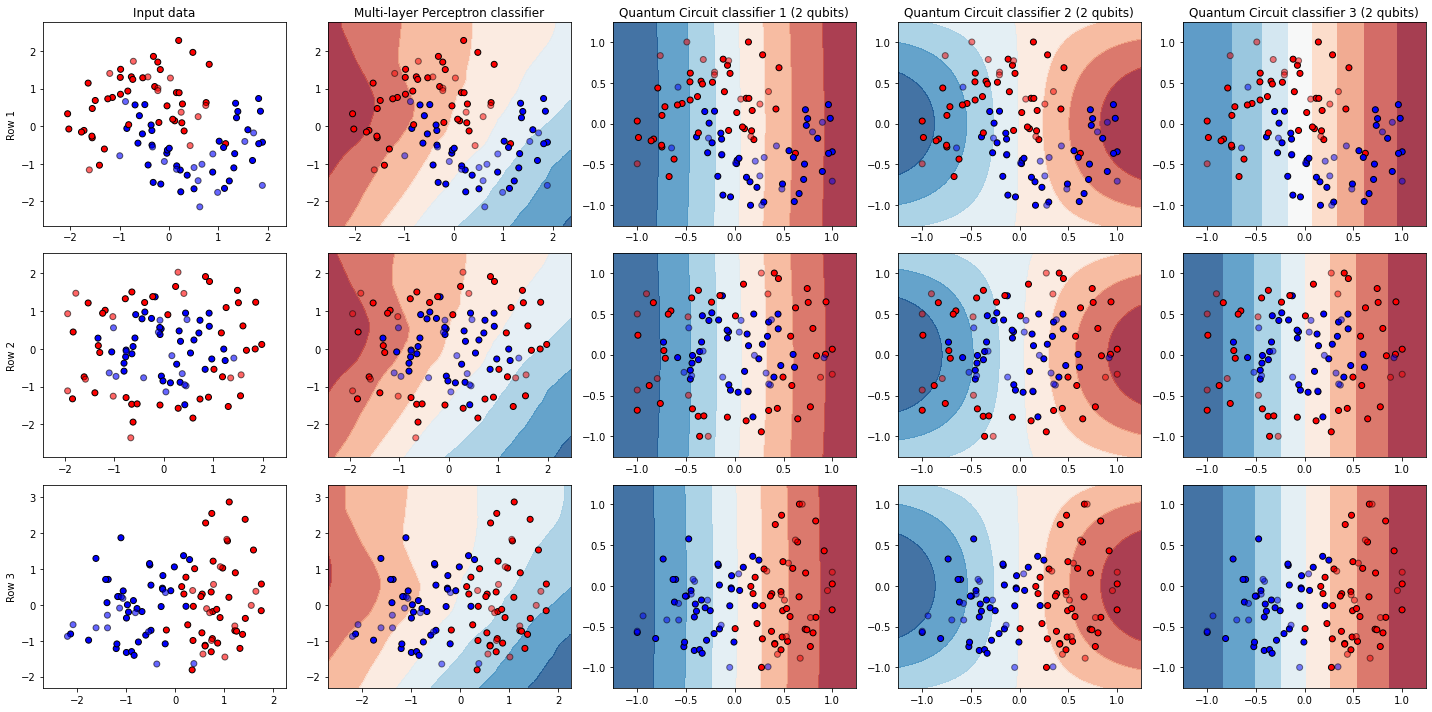

scores: [[[0.64 0.64 0.16]
  [0.64 0.64 0.16]]

 [[0.36 0.44 0.92]
  [0.36 0.44 0.92]]

 [[0.36 0.36 0.96]
  [0.32 0.36 0.92]]

 [[0.32 0.36 0.92]
  [0.32 0.36 0.92]]]


In [51]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    "Quantum Circuit classifier 1 (2 qubits)",
    "Quantum Circuit classifier 2 (2 qubits)",
    "Quantum Circuit classifier 3 (2 qubits)",
]

classifiers = [
  MLPClassifier(random_state=1, max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  print("Loop count:", l_count)
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')
  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds

      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )

      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=1
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      # ax.set_xticks(())
      # ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
          
          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )
            
            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())

            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #     xx.max() - 0.3,
            #     yy.min() + 0.3,
            #     ("Score: %.2f" % score).lstrip("0"),
            #     size=15,
            #     horizontalalignment="right",
            # )
            
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)


In [52]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (2 qubits)
 0: ──H──RY(1.24)──╭C──Rot(0.00625, -0.0214, 0.00247)──╭C──┤ ⟨Z⟩ 
 1: ──H──RY(1.24)──╰X──Rot(0.00118, 0.00341, 0.00116)──╰X──┤     

Quantum Circuit classifier 2 (2 qubits)
 0: ──H──RY(1.24)──RX(1.24)──╭C──Rot(0.0116, 0.00102, -0.0143)────╭C──┤ ⟨Z⟩ 
 1: ──H──────────────────────╰X──Rot(0.0133, -0.00638, 0.000783)──╰X──┤     

Quantum Circuit classifier 3 (2 qubits)
 0: ──H──RY(1.24)──╭C──Rot(0.00578, -0.00197, -0.0011)──╭C──┤ ⟨Z⟩ 
 1: ──H──RX(1.24)──╰X──Rot(0.00152, 0.00738, -0.00871)──╰X──┤     



/Users/phuber/opt/anaconda3/lib/python3.9/site-packages/pennylane/qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
